Environment created!
[10.]
model created!
The reward for this game was -9753.0
The average Q error for this game was 9540.964527027027


C:\Users\raymo\AppData\Local\Temp\ipykernel_5772\3284788500.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.history[-1] = np.float32(self.current_value)  # Ensure it's a scalar
C:\Users\raymo\AppData\Local\Temp\ipykernel_5772\3284788500.py:86: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = -float((self.current_value - self.target_value) ** 2)  # Ensure the reward is a float


The reward for this game was -9548.0
The average Q error for this game was 8524.82637859261
The reward for this game was -9474.0
The average Q error for this game was 6627.355465530846
The reward for this game was -9476.0
The average Q error for this game was 5258.043148640709
The reward for this game was -9347.0
The average Q error for this game was 4432.797386082141
The reward for this game was -9476.0
The average Q error for this game was 3938.6299620615923
The reward for this game was -9298.0
The average Q error for this game was 3631.5568471576207
The reward for this game was -9140.0
The average Q error for this game was 3482.825143987482
The reward for this game was -9288.0
The average Q error for this game was 3507.575527150144
The reward for this game was -9197.0
The average Q error for this game was 3572.3886957402674
The reward for this game was -9423.0
The average Q error for this game was 3681.621854136512
The reward for this game was -9402.0
The average Q error for this ga

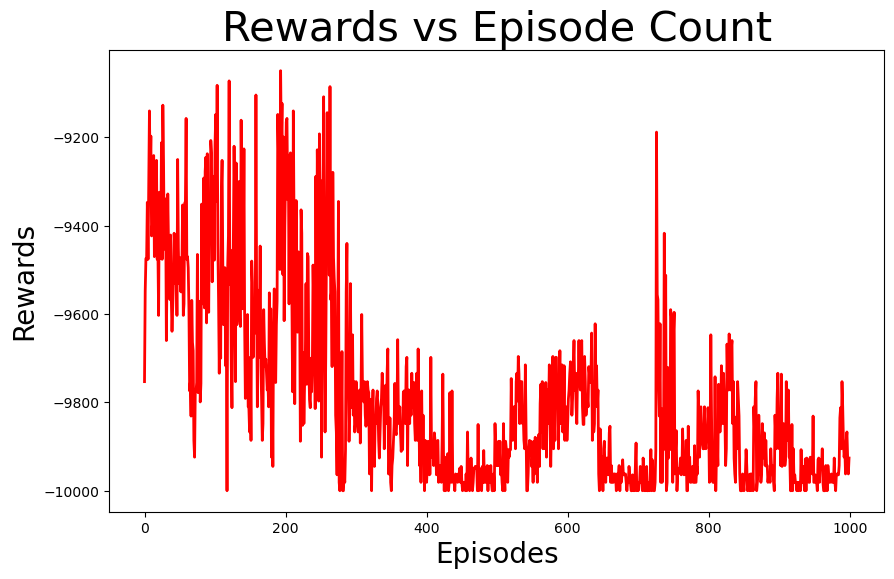

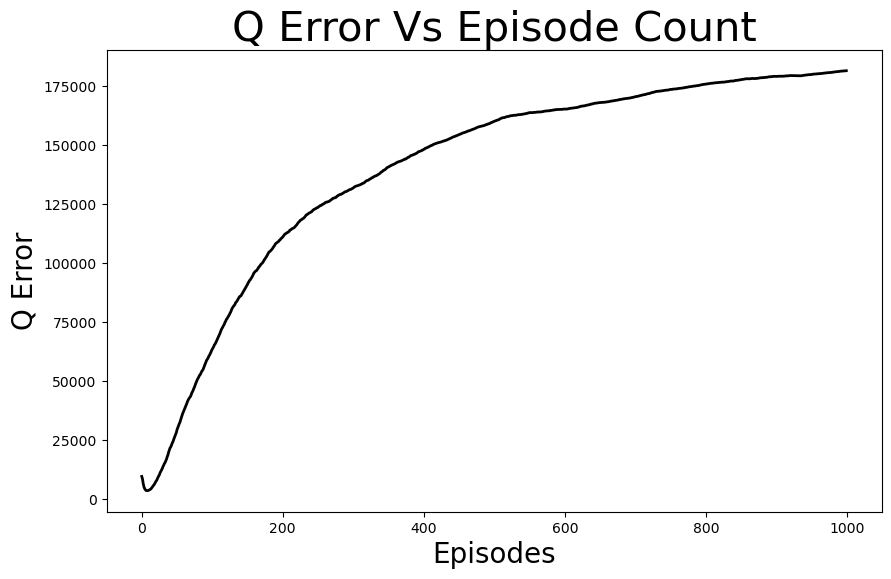

Total time taken: 245.9573736190796 seconds
Total time taken by training: 211.87798857688904 seconds
Total time taken by predicting: 27.004745483398438 seconds


In [12]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from collections import deque
import time
import random

from gymnasium import spaces

class OneMoleculeEnv(gym.Env):
    def __init__(self, initial_value=10, molecule_lifetime = 1, dt = 0.1, max_steps=100, history_length=5, target_value=10, obs_cap=100, render_mode=None):
        super(OneMoleculeEnv, self).__init__()

        self.initial_value = initial_value
        self.molecule_lifetime = molecule_lifetime
        self.dt = dt
        self.max_steps = max_steps
        self.history_length = history_length
        self.target_value = target_value
        self.obs_cap = obs_cap  # Cap for the observation space
        self.render_mode = render_mode

        self.current_value = initial_value
        self.current_step = 0

        # Define action and observation space
        self.action_space = spaces.Discrete(obs_cap)  # the number of molecules to send in ranges from 0 to the cap
        self.observation_space = spaces.Box(
            low=0, high=obs_cap, shape=(history_length,), dtype=np.float32
        )

        # Initialize the history of values
        self.history = np.full(history_length, initial_value, dtype=np.float32)

        # Pre-generate random numbers to avoid generating them at each step
        self.random_numbers = np.random.rand(max_steps)

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
            self.random_numbers = np.random.rand(self.max_steps)  # Re-generate random numbers if seeded
        self.current_value = self.initial_value
        self.current_step = 0
        self.history = np.full(self.history_length, self.initial_value, dtype=np.float32)
        return self.history, {}

    def _ensure_random_numbers(self):
        # Reset the random numbers if current_step exceeds max_steps
        if self.current_step >= self.max_steps:
            self.random_numbers = np.random.rand(self.max_steps)
            self.current_step = 0  # Reset current step to start fresh

    def step(self, action):
        # Apply action
        #if action == 1:
        self.current_value += action
        # Ensure enough random numbers are available
        self._ensure_random_numbers()

        # Decrease the value with a number drawn from a binomial distribution
        # This reflects each molecule having a finite probability of decaying in the timestep
        # The probability a molecule has decayed in the time interval given is
        self.prob_death = np.exp(-self.dt/self.molecule_lifetime)
        
        self.current_value += -np.random.binomial(self.current_value, self.prob_death, 1)

        # Cap the current value to obs_cap
        self.current_value = min(self.current_value, self.obs_cap)

        # Update the history using a simple list rotation
        self.history[:-1] = self.history[1:]
        self.history[-1] = np.float32(self.current_value)  # Ensure it's a scalar

        # Increment step count
        self.current_step += 1

        # Check if done
        done = self.current_step >= self.max_steps

        # Calculate reward
        reward = -float((self.current_value - self.target_value) ** 2)  # Ensure the reward is a float

        return self.history, reward, done, done, {}

    def render(self):
        if self.render_mode == 'human':
            print(f"Step: {self.current_step}, Value: {self.current_value}, History: {self.history}")

    def close(self):
        pass

# Register the environment
gym.envs.registration.register(
    id='OneMoleculeEnv-v0',
    entry_point=OneMoleculeEnv,
    max_episode_steps=1000000,
)

# Start the timer
start_time = time.time()

total_time_train = 0
total_time_predict = 0

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def add(self, experience):
        self.memory.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


def select_action_with_epsilon_greedy(Q_value, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        return np.argmax(Q_value)

def step_function(model, target_model, optimizer, loss_fn, s, a, r, d, ns, discount):
    model.train()
    
    qs = model(s)
    qa = qs.gather(1, a)

    done_mask = (d == 0)
    
    with torch.no_grad():
        next_qs = target_model(ns)
        max_next_qs = torch.max(next_qs, dim=1, keepdim=True)[0]
        target = r + discount * torch.where(done_mask, max_next_qs, torch.tensor(0))
    
    loss = loss_fn(qa, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def train_from_memory(model, target_model, optimizer, loss_fn, replay_memory, batch_size, discount):
    if len(replay_memory) < batch_size:
        return 0

    batch = replay_memory.sample(batch_size)
    state_list, action_list, reward_list, next_state_list, done_list = zip(*batch)

    states = torch.tensor(np.array(state_list), dtype=torch.float32)
    actions = torch.tensor(np.array(action_list), dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(np.array(reward_list), dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(np.array(next_state_list), dtype=torch.float32)
    dones = torch.tensor(np.array(done_list), dtype=torch.float32).unsqueeze(1)

    loss = step_function(model, target_model, optimizer, loss_fn, states, actions, rewards, dones, next_states, discount)
    return loss
    
#When to stop training
def terminate_performance(rewards_overtime, max_reward, consistent_perf):
    # Get the last 3 elements
    last_three = rewards_overtime[-consistent_perf:]

    # Calculate the average
    average = np.mean(last_three)
    if average > max_reward -1:
        return True
    return False

##Saving and loading our results
def save_model(model, optimizer, filename):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, filename)
    print(f"Model and optimizer state saved to {filename}")

def save_arrays(rewards_overtime, error_over_episodes, rewards_filename, errors_filename):
    np.savetxt(rewards_filename, rewards_overtime, delimiter=',')
    np.savetxt(errors_filename, error_over_episodes, delimiter=',')
    print(f"Rewards saved to {rewards_filename}")
    print(f"Q errors saved to {errors_filename}")

##This is dependent on the gymnasium environment
def environment_train(env, model, target_model, optimizer, loss_fn, replay_memory, RUN_SEED, MAX_STEPS, VISIBLE, batch_size, discount, epsilon_start, epsilon_end, epsilon_decay, total_time_train, total_time_predict):
    observation, info = env.reset(seed=RUN_SEED)
    total_reward = 0

    rewards_overtime = []
    error_over_episodes = []
    error_in_episode = []

    epsilon = epsilon_start
    steps = 0
    play = True

    ##Implementing a target network to make training more stable with DQN
    target_update_freq = 100

    while play:
        start_time = time.time()
        observation_tensor = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            Q_values = model(observation_tensor)
        action = select_action_with_epsilon_greedy(Q_values.numpy(), epsilon)
        next_observation, reward, done, truncated, info = env.step(action)

        replay_memory.add((observation, action, reward, next_observation, done))
        observation = next_observation
        
        end_time = time.time()
        total_time_predict += (end_time - start_time)
        
        start_time = time.time()
        q_error = train_from_memory(model, target_model, optimizer, loss_fn, replay_memory, batch_size, discount)
        if q_error > 0:
            error_in_episode.append(q_error)
        end_time = time.time()
        
        total_time_train += (end_time - start_time)
        
        total_reward += reward
        if done or truncated:
            average_error = np.mean(error_in_episode) if error_in_episode else 0
            print("The reward for this game was", total_reward)
            print("The average Q error for this game was", average_error)
            error_over_episodes.append(average_error)
            rewards_overtime.append(total_reward)
            total_reward = 0
            observation, info = env.reset()

        if steps % target_update_freq == 0:
            target_model.load_state_dict(model.state_dict())
    
        epsilon = max(epsilon * epsilon_decay, epsilon_end)
        steps += 1
        if steps > MAX_STEPS:
            play = False
        if terminate_performance(rewards_overtime, 500, 5):
            play = False
    env.close()
    return rewards_overtime, error_over_episodes, total_time_train, total_time_predict, steps

##Here we choose our environment

env = gym.make('OneMoleculeEnv-v0', initial_value=10, molecule_lifetime = 1, dt = 0.1, max_steps=100, history_length=1, target_value=10, obs_cap=100, render_mode=None)
print('Environment created!')

observation, info = env.reset(seed=RUN_SEED)
print (observation)
    
model = NeuralNetwork(input_dim = 1, output_dim = 5)
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
target_model = NeuralNetwork(input_dim = 1, output_dim = 5)
target_model.load_state_dict(model.state_dict())
print('model created!')

replay_memory = ReplayMemory(capacity=2000)

RUN_SEED = 0
MAX_STEPS = 100000
VISIBLE = False
batch_size = 64
discount = 0.99
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 0.995

rewards_overtime, error_overtime, total_time_train, total_time_predict, steps = environment_train(env, model, target_model, optimizer, loss_fn, replay_memory, RUN_SEED, MAX_STEPS, VISIBLE, batch_size, discount, epsilon_start, epsilon_end, epsilon_decay, total_time_train, total_time_predict)
print ("Terminated learning at step ", steps)
print("The rewards over time are", rewards_overtime)

end_time = time.time()
total_time = end_time - start_time

model_filename = 'one_molecule_model.pth'
save_model(model, optimizer, model_filename)

rewards_filename = 'molecule_rewards.txt'
errors_filename = 'molecule_error.txt'
save_arrays(np.array(rewards_overtime), np.array(error_overtime), rewards_filename, errors_filename)

size = len(rewards_overtime)
episode_num = np.arange(size)

plt.figure(figsize=(10, 6))
plt.plot(episode_num, rewards_overtime, 'r-', lw=2)
plt.title('Rewards vs Episode Count', fontsize = 30)
plt.xlabel('Episodes', fontsize = 20)
plt.ylabel('Rewards', fontsize = 20)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(episode_num, error_overtime, 'k-', lw=2)
plt.title('Q Error Vs Episode Count', fontsize = 30)
plt.xlabel('Episodes', fontsize = 20)
plt.ylabel('Q Error', fontsize = 20)
plt.show()

print(f"Total time taken: {total_time} seconds")
print(f"Total time taken by training: {total_time_train} seconds")
print(f"Total time taken by predicting: {total_time_predict} seconds")